# Initial Setup

## Importing Libraries



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier, RandomForestClassifier


import re

In [2]:
from sklearn import __version__ as sklearn_version
from platform import python_version 
from matplotlib import __version__ as mp_version

print("python version:  ", python_version())
print("nltk version:    ", nltk.__version__)
print("pandas version:  ", pd.__version__)
print("numpy version:   ", np.__version__)
print("sklearn version: ", sklearn_version)
print("matplotlib version:  ", mp_version)


python version:   3.10.4
nltk version:     3.7
pandas version:   1.4.2
numpy version:    1.22.4
sklearn version:  1.1.1
matplotlib version:   3.5.2


Package versions used:

```
python version:   3.9.7
nltk version:     3.6.7
pandas version:   1.3.3
numpy version:    1.20.3
sklearn version:  1.0.2
matplotlib version:   3.4.3
```

## Setting Variables

In [3]:
plt.style.use('seaborn-paper')
plt.rcParams['figure.dpi'] = 128

In [4]:
RANDOM_STATE = 1
np.random.seed(RANDOM_STATE)

## Loading Data

In [5]:
url1 = 'https://raw.githubusercontent.com/joanamftavares/text-mining/main/data/dev_set.txt'
dev_set = pd.read_csv(url1, delimiter='\t')
dev_set

,sentence,emotion
0,What happens to the gold in our safe ?,4
1,Natural to get cold feet .,8
2,"Not very lucky , is he ?",7
3,I'm just a little anxious to get up there and ...,2
4,Did you think we don't know about your affair ...,1
...,...,...
995,All I ask of you is be careful .,4
996,"You don't like jazz , pal ?",7
997,Put it on .,1
998,Can you ever imagine [PERSON] being in a spot ...,7


In [6]:
url2 = 'https://raw.githubusercontent.com/joanamftavares/text-mining/main/data/training_set.txt'
train_set = pd.read_csv(url2, delimiter='\t')
train_set

,sentence,emotion
0,I'm too old to be traded in .,6
1,Mother said you could always tell a lady by he...,8
2,I always said I'd leave off when the time came .,6
3,He'll be safe with me .,2
4,Lay off .,1
...,...,...
13995,"Yes , Commissioner .",8
13996,The ring !,7
13997,That is my greatest and most enduring love .,5
13998,"When I came back from the war , I had a son .",5


# Baseline Preprocessing

In [7]:
## Uncomment these on first run
#nltk.download('omw-1.4')
#nltk.download('averaged_perceptron_tagger')


In [8]:
stop = text.ENGLISH_STOP_WORDS
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [9]:
def stem_sentences(sentence):
    tokens = sentence.split()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

def lemmatize_sentences(sentence):
    tokens = sentence.split()
    lemmd_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmd_tokens)

def basic_preprocessing(df_, col, stop=[]):
    
    df = df_.copy()
    df['original'] = df[col]
    """
    Baseline preprocessing: 
        - lowercase
        - remove symbols (keep letters, ?, !)
        - remove stop words
        - use stemming
    """
    keep = ['?', '!']
    
    ## Lowercase
    df[col] = df[col].str.lower()
    
    ## Remove symbols
    df[col] = df[col].apply(lambda x: ''.join([re.sub(r'[\.;:,\"\'\/]','',x)]))
    
    ## Remove the extra space left before symbols
    ## e.g. "who are you ?" >> "who are you?"
    ## Not sure if this should be done, comment out if not
    ## df[col] = df[col].apply(lambda x: str.replace(x,' ?','?'))
    ## df[col] = df[col].apply(lambda x: str.replace(x,' !','!'))

    
    ## Remove stop words ?
    ## https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a
    if len(stop) > 0:
        df[col] = df[col].apply(lambda x: ' '.join([word for word in x.split(' ') if word not in (stop)]))
    
    ## Use Stemming
    df[col] = df[col].apply(lambda x: stem_sentences(x) )
    
    ## Remove excess space
    df[col] = df[col].str.strip()
    
    return df


def text_preprocessing(df_, col, stop=[]):
    
    df = df_.copy()
    df['original'] = df[col]
    """
    Baseline preprocessing: 
        - lowercase
        - remove symbols (keep letters, ?, !)
        - remove stop words in pipeline instead of in preprocessing
        - use lemmatizing instead 
    """
    keep = ['?', '!']
    
    ## Lowercase
    df[col] = df[col].str.lower()
    
    ## Remove symbols
    df[col] = df[col].apply(lambda x: ''.join([re.sub(r'[\.;:,\"\'\/]','',x)]))
        
    ## Use Lemmatizer
    df[col] = df[col].apply(lambda x: lemmatize_sentences(x) )
    
    ## Remove excess spaces
    df[col] = df[col].apply(lambda x: re.sub(' +', ' ', x))
    df[col] = df[col].str.strip()
    
    return df

In [10]:
train_set_prep_basic = basic_preprocessing(train_set, 'sentence', stop)
train_set_prep = text_preprocessing(train_set, 'sentence', stop)


In [11]:
#stop

In [12]:
dev_set_prep_basic = basic_preprocessing(dev_set, 'sentence', stop)
dev_set_prep = text_preprocessing(dev_set, 'sentence', stop)


# Data Understanding

In [13]:
labels = {
    1: 'Anger',
    2: 'Anticipation',
    3: 'Digust',
    4: 'Fear',
    5: 'Joy',
    6: 'Sadness',
    7: 'Surprise',
    8: 'Trust',
}

In [14]:
X_train_basic = train_set_prep_basic['sentence']
Y_train_basic = train_set_prep_basic['emotion']

X_dev_basic = dev_set_prep_basic['sentence']
Y_dev_basic = dev_set_prep_basic['emotion']

In [15]:
X_train = train_set_prep['sentence']
Y_train = train_set_prep['emotion']

X_dev = dev_set_prep['sentence']
Y_dev = dev_set_prep['emotion']

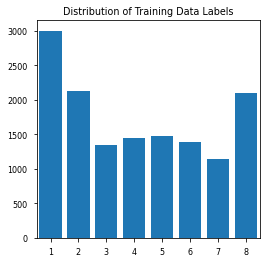

In [16]:
fig, ax = plt.subplots(figsize=(4,4))
y_counts = np.bincount(Y_train)
ax.bar(range(0,9), y_counts)
ax.set(xticks=range(1,9), xlim=[0.5, 8.5])

plt.title("Distribution of Training Data Labels")
plt.show()

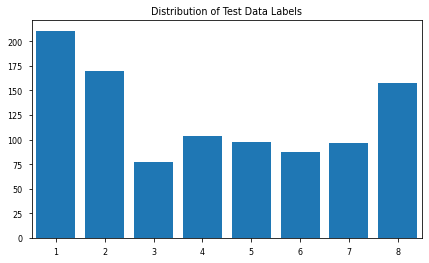

In [17]:
fig, ax = plt.subplots(figsize=(7,4))
y_counts = np.bincount(Y_dev)
ax.bar(range(0,9), y_counts)
ax.set(xticks=range(1,9), xlim=[0.5, 8.5])

plt.title("Distribution of Test Data Labels")
plt.show()

# Model Selection

In [18]:
f1labels = ["F1 " + labels[i+1] for i in range(len(labels))]
rclabels = ["Recall " + labels[i+1] for i in range(len(labels))]
pclabels = ["Precision " + labels[i+1] for i in range(len(labels))]
numlabels = [i+1 for i in range(len(labels))]


In [19]:
def get_scores(preds, label, cv_score, truth=Y_dev):
    return pd.DataFrame([[label,
               accuracy_score(truth, preds),
               recall_score(truth, preds, average='macro'),
               precision_score(truth, preds, average='macro'),
               f1_score(truth, preds, average='macro', ),
               cv_score,
               *(f1_score(truth, preds, average=None, labels=numlabels)),
               *(recall_score(truth, preds, average=None, labels=numlabels)),
               *(precision_score(truth, preds, average=None, labels=numlabels)),
            ]],
             columns=["Model", "Accuracy", "Recall", "Precision", "F1", "Train Accuracy", *f1labels, *rclabels, *pclabels ],
             index=[label]
        )
    
def print_scores(preds, gs_, Y=Y_dev):
    
    print("Best parameters: ")
    print(gs_.best_params_)
    print("------------------------")

    print("Accuracy:         ", round(accuracy_score(Y_dev, preds),4))
    print("Macro F1:         ", round(f1_score(Y_dev, preds, average='macro'),4))
    print("Macro Recall:     ", round(recall_score(Y_dev, preds, average='macro'),4))
    print("Macro Precision:  ", round(precision_score(Y_dev, preds, average='macro'),4))
    print("Best Train Score: ", round(gs_.best_score_,4))

    return

def plot_cm(preds, title, Y=Y_dev):
    cm_ = confusion_matrix(Y, preds)
    df_cm = pd.DataFrame(cm_, index=numlabels, columns=numlabels)
    
    fig, ax = plt.subplots(figsize=(7,5))
    
    ax = sns.heatmap(df_cm, annot=True,cmap="Blues", fmt="d")
    ax.set_ylabel("True Label")
    ax.set_xlabel("Predicted Label")
    
    plt.title("Confusion Matrix: "+title, fontsize=12)
    
    
    plt.show()
    #fn = './imgs03/ConfusionMatrix_' + title.replace(' ','-') + '.png'
    #fig.savefig(fn, bbox_inches='tight', transparent=True)
    
    return



In [20]:
score_func = 'accuracy'

## Baseline KNN

In [21]:
pipe_knn = Pipeline([
    ('count', CountVectorizer()),     # CountVectorizer 
    ('classifier', KNeighborsClassifier()),  # 
])

## Uses values of default params as grid search values
grid_knn = {
    "count__ngram_range": [(1,1)],
    "count__stop_words": [None],
}

gs_knn = GridSearchCV(pipe_knn, grid_knn, n_jobs=-1, cv=10, scoring=score_func)
gs_knn.fit(X_train_basic, Y_train_basic)
gs_knn_pred = gs_knn.predict(X_dev_basic)


In [22]:
print_scores(gs_knn_pred, gs_knn)
scores = get_scores(gs_knn_pred, "KNN Baseline", gs_knn.best_score_)
#plot_cm(gs_knn_pred, "Baseline")

Best parameters: 
{'count__ngram_range': (1, 1), 'count__stop_words': None}
------------------------
Accuracy:          0.265
Macro F1:          0.2125
Macro Recall:      0.2181
Macro Precision:   0.2295
Best Train Score:  0.2555


## KNN Optimized

In [23]:
pipe_knno = Pipeline([
    ('count', CountVectorizer()),     # CountVectorizer 
    ('knn', KNeighborsClassifier()),  # 
])

## Uses values of default params as grid search values
grid_knno = {
    "count__ngram_range": [(1,1)],
    "count__stop_words": [None],
    "knn__n_neighbors": [19],
    "knn__metric": ['cosine'],
    'knn__weights':['distance']
    
}

gs_knno = GridSearchCV(pipe_knno, grid_knno, n_jobs=-1, cv=10, scoring=score_func)
gs_knno.fit(X_train, Y_train)
gs_knno_pred = gs_knno.predict(X_dev)

Best parameters: 
{'count__ngram_range': (1, 1), 'count__stop_words': None, 'knn__metric': 'cosine', 'knn__n_neighbors': 19, 'knn__weights': 'distance'}
------------------------
Accuracy:          0.316
Macro F1:          0.2656
Macro Recall:      0.268
Macro Precision:   0.2957
Best Train Score:  0.3173


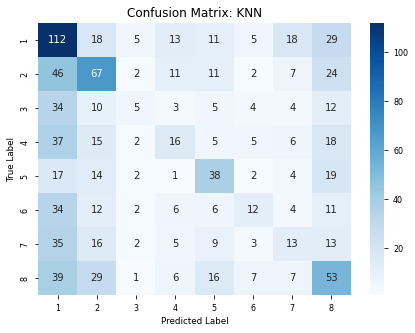

In [25]:
print_scores(gs_knno_pred, gs_knno)
scores = pd.concat([scores,get_scores(gs_knno_pred, "KNN", gs_knno.best_score_)])
plot_cm(gs_knno_pred, "KNN")

## MNB

In [26]:
pipe_mnb = Pipeline([
    ('count', CountVectorizer()),     # CountVectorizer 
    ('classifier', MultinomialNB()),  # 
])

## Uses values of default params as grid search values
grid_mnb = {
    "count__ngram_range": [(1,1)],
    "count__stop_words": [None],
    "classifier__alpha": [0.1]
}

gs_mnb = GridSearchCV(pipe_mnb, grid_mnb, n_jobs=-1, cv=10, scoring=score_func)

gs_mnb.fit(X_train, Y_train)
gs_mnb_pred = gs_mnb.predict(X_dev)


In [27]:
print_scores(gs_mnb_pred, gs_mnb)
scores = pd.concat([scores,get_scores(gs_mnb_pred, "MultinomialNB", gs_mnb.best_score_)])


Best parameters: 
{'classifier__alpha': 0.1, 'count__ngram_range': (1, 1), 'count__stop_words': None}
------------------------
Accuracy:          0.362
Macro F1:          0.3428
Macro Recall:      0.3414
Macro Precision:   0.3505
Best Train Score:  0.364


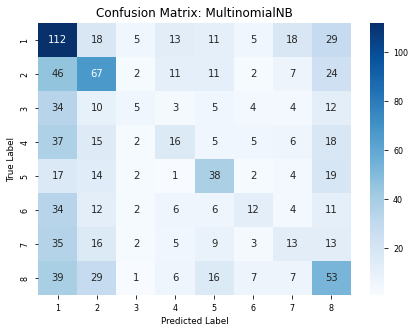

In [28]:
plot_cm(gs_knno_pred, "MultinomialNB")

## SGD

In [29]:
pipe_sgd = Pipeline([
    ('count', CountVectorizer()),
    ('sgd', SGDClassifier(random_state=RANDOM_STATE, max_iter=8000)),
])

grid_sgd = {
    "count__ngram_range": [(1,1)],
    "count__stop_words": [None],
    "sgd__loss": ['log_loss'], 
    "sgd__penalty":['l2'],
    "sgd__alpha":[0.001]
}

gs_sgd = GridSearchCV(pipe_sgd, grid_sgd, n_jobs=-1, cv=10, scoring=score_func)
gs_sgd.fit(X_train, Y_train)

gs_sgd_pred = gs_sgd.predict(X_dev)



In [30]:
print_scores(gs_sgd_pred, gs_sgd)
get_scores(gs_sgd_pred, "SGD", gs_sgd.best_score_)

scores = pd.concat([scores,get_scores(gs_sgd_pred, "SGDClassifier", gs_sgd.best_score_)])

Best parameters: 
{'count__ngram_range': (1, 1), 'count__stop_words': None, 'sgd__alpha': 0.001, 'sgd__loss': 'log_loss', 'sgd__penalty': 'l2'}
------------------------
Accuracy:          0.372
Macro F1:          0.3047
Macro Recall:      0.3083
Macro Precision:   0.3736
Best Train Score:  0.3564


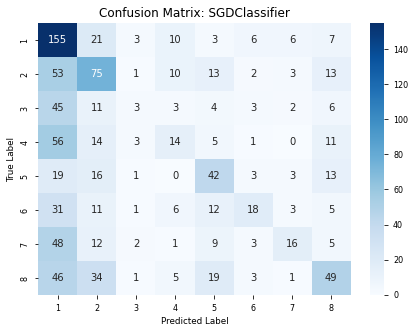

In [31]:
plot_cm(gs_sgd_pred, "SGDClassifier")

## LR

In [32]:
pipe_lr = Pipeline([
    ('count', CountVectorizer()),
    ('lr', LogisticRegression(random_state=RANDOM_STATE, max_iter=8000)),
])

grid_lr = {
    "count__ngram_range": [(1,1)],
    "count__stop_words": [None],
    "lr__solver": ['liblinear'],
    "lr__multi_class": ['auto'],
}

gs_lr = GridSearchCV(pipe_lr, grid_lr, n_jobs=-1, cv=10, scoring=score_func)

gs_lr.fit(X_train, Y_train)
gs_lr_pred = gs_lr.predict(X_dev)


In [33]:
print_scores(gs_lr_pred, gs_lr)
get_scores(gs_lr_pred, "LogisticRegression", gs_lr.best_score_)

scores = pd.concat([scores,get_scores(gs_lr_pred, "LogisticRegression", gs_lr.best_score_)])


Best parameters: 
{'count__ngram_range': (1, 1), 'count__stop_words': None, 'lr__multi_class': 'auto', 'lr__solver': 'liblinear'}
------------------------
Accuracy:          0.37
Macro F1:          0.3431
Macro Recall:      0.3403
Macro Precision:   0.3572
Best Train Score:  0.3799


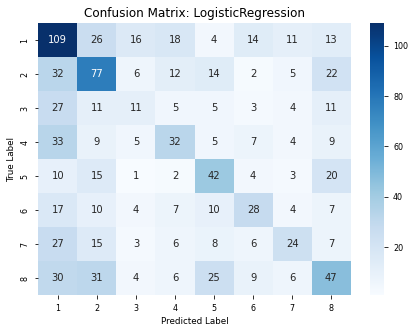

In [34]:
plot_cm(gs_lr_pred, "LogisticRegression")

## DT

In [38]:
pipe_dt = Pipeline([
    ('count', CountVectorizer()),
    ('dt', DecisionTreeClassifier(random_state=RANDOM_STATE)),
])

grid_dt = {
    "count__ngram_range": [(1,1)],
    "count__stop_words": ["english"],
    "dt__criterion": ['gini'],
    "dt__splitter": ['best'],
    "dt__max_features":['sqrt']
    
}

gs_dt = GridSearchCV(pipe_dt, grid_dt, n_jobs=-1, cv=10, scoring=score_func)

gs_dt.fit(X_train, Y_train)
gs_dt_pred = gs_dt.predict(X_dev)


In [39]:
print_scores(gs_dt_pred, gs_dt)
get_scores(gs_dt_pred, "DecisionTreeClassifier", gs_dt.best_score_)

scores = pd.concat([scores,get_scores(gs_dt_pred, "DecisionTreeClassifier", gs_dt.best_score_)])


Best parameters: 
{'count__ngram_range': (1, 1), 'count__stop_words': 'english', 'dt__criterion': 'gini', 'dt__max_features': 'sqrt', 'dt__splitter': 'best'}
------------------------
Accuracy:          0.303
Macro F1:          0.2552
Macro Recall:      0.258
Macro Precision:   0.2669
Best Train Score:  0.2844


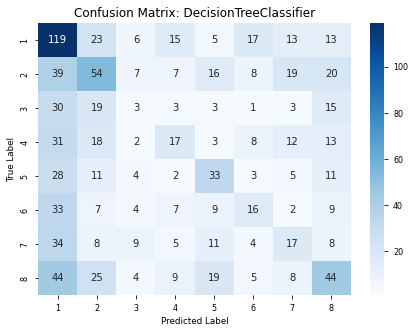

In [40]:
plot_cm(gs_dt_pred, "DecisionTreeClassifier")

## GB

In [41]:
pipe_gb = Pipeline([
    ('count', CountVectorizer()),
    ('gb', GradientBoostingClassifier(random_state=RANDOM_STATE)),
])

grid_gb = {
    "count__ngram_range": [(1,1)],
    "count__stop_words": [None],
    "gb__loss": ['log_loss'],
    "gb__n_estimators": [200],
    "gb__learning_rate": [.25],    
}

gs_gb = GridSearchCV(pipe_gb, grid_gb, n_jobs=-1, cv=10, scoring=score_func)

gs_gb.fit(X_train, Y_train)
gs_gb_pred = gs_gb.predict(X_dev)


In [42]:
print_scores(gs_gb_pred, gs_gb)
get_scores(gs_gb_pred, "GradientBoostingClassifier", gs_gb.best_score_)

scores = pd.concat([scores,get_scores(gs_gb_pred, "GradientBoostingClassifier", gs_dt.best_score_)])


Best parameters: 
{'count__ngram_range': (1, 1), 'count__stop_words': None, 'gb__learning_rate': 0.25, 'gb__loss': 'log_loss', 'gb__n_estimators': 200}
------------------------
Accuracy:          0.34
Macro F1:          0.2986
Macro Recall:      0.2919
Macro Precision:   0.3394
Best Train Score:  0.3498


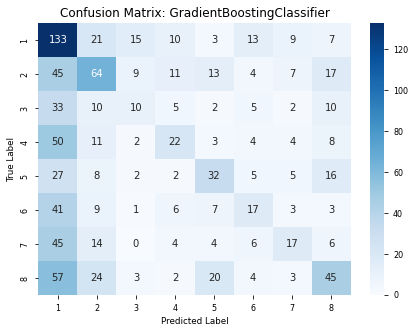

In [43]:
plot_cm(gs_gb_pred, "GradientBoostingClassifier")

## SVM

In [44]:
pipe_sv = Pipeline([
    ('count', CountVectorizer()),
    ('svc', SVC(random_state=RANDOM_STATE)),
])

grid_sv = {
    "count__ngram_range": [(1,1)],
    "count__stop_words": [None],
    "svc__kernel": ['linear'],
    "svc__gamma":['scale'],
    "svc__decision_function_shape": ['ovo'],
}

gs_sv = GridSearchCV(pipe_sv, grid_sv, n_jobs=-1, cv=10, scoring=score_func)

gs_sv.fit(X_train, Y_train)
gs_sv_pred = gs_sv.predict(X_dev)


In [45]:
print_scores(gs_sv_pred, gs_sv)
get_scores(gs_sv_pred, "SVC", gs_sv.best_score_)

scores = pd.concat([scores,get_scores(gs_sv_pred, "SVC", gs_sv.best_score_)])

Best parameters: 
{'count__ngram_range': (1, 1), 'count__stop_words': None, 'svc__decision_function_shape': 'ovo', 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
------------------------
Accuracy:          0.372
Macro F1:          0.3421
Macro Recall:      0.338
Macro Precision:   0.3557
Best Train Score:  0.3736


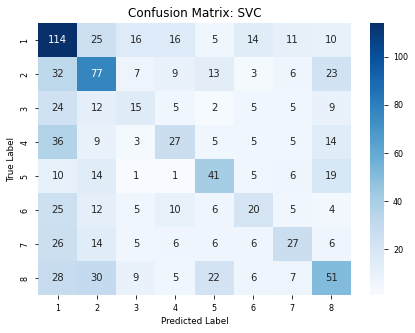

In [46]:
plot_cm(gs_sv_pred, "SVC")

## VotingClassifier

### Hard

#### Using optimized base estimators

LR = {'count__ngram_range': (1, 1), 'count__stop_words': None, 'lr__multi_class': 'multinomial', 'lr__solver': 'lbfgs'}

SG = {'count__ngram_range': (1, 1), 'count__stop_words': None, 'sgd__alpha': 0.001, 'sgd__loss': 'log', 'sgd__penalty': 'l2'}

NB = {'classifier__alpha': 0.1, 'count__ngram_range': (1, 1), 'count__stop_words': None}

GB = {'count__ngram_range': (1, 1), 'count__stop_words': None, 'gb__learning_rate': 0.25, 'gb__loss': 'log_loss', 'gb__n_estimators': 200}

SV = {'count__ngram_range': (1, 1), 'count__stop_words': None, 'svc__decision_function_shape': 'ovo', 'svc__gamma': 'scale', 'svc__kernel': 'linear'}

In [23]:
vc = VotingClassifier(
    estimators=[('lr', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, solver='lbfgs', multi_class='multinomial')), 
                ('sg', SGDClassifier(random_state=RANDOM_STATE, loss='log', penalty='l2', alpha=0.001)), 
                ('nb', MultinomialNB(alpha=.1)),
                ('gb', GradientBoostingClassifier(random_state=RANDOM_STATE, loss='log_loss', n_estimators=200, learning_rate=.25)),
                ('sv', SVC(random_state=RANDOM_STATE, kernel='linear', decision_function_shape='ovo', gamma='scale'))
               ],
    voting='hard'
)

vc_pipe = Pipeline([
        ('count', CountVectorizer()),    
        ('vc', vc)
    ])


grid_vc = {
    "count__ngram_range": [(1,1)],
    "count__stop_words": [None]
}

gs_vc = GridSearchCV(vc_pipe, grid_vc, n_jobs=-1, cv=10, scoring=score_func)

gs_vc.fit(X_train, Y_train)
gs_vc_pred = gs_vc.predict(X_dev)



C:\Users\Joana Tavares\anaconda3\envs\tm\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


In [24]:
print_scores(gs_vc_pred, gs_vc)
get_scores(gs_vc_pred, "VotingClassifier", gs_vc.best_score_)

scores = pd.concat([scores,get_scores(gs_vc_pred, "VotingClassifier", gs_vc.best_score_)])


Best parameters: 
{'count__ngram_range': (1, 1), 'count__stop_words': None}
------------------------
Accuracy:          0.381
Macro F1:          0.3457
Macro Recall:      0.3394
Macro Precision:   0.3808
Best Train Score:  0.3826


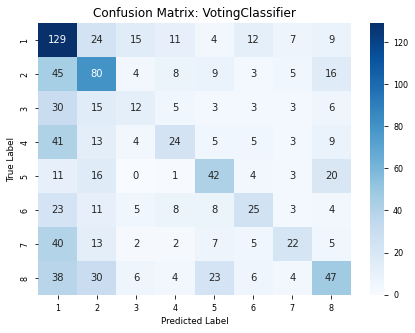

In [25]:
plot_cm(gs_vc_pred, "VotingClassifier")

## RF

In [ ]:
pipe_rf = Pipeline([
    ('count', CountVectorizer()),
    ('rf', RandomForestClassifier(random_state=RANDOM_STATE)),
])

grid_rf = {
    "count__ngram_range": [(1,1)],
    "count__stop_words": [None],
    "rf__n_estimators": [200],
    "rf__criterion": ['gini'],
    "rf__max_features":['log2']

}

gs_rf = GridSearchCV(pipe_rf, grid_rf, n_jobs=-1, cv=10, scoring=score_func)

gs_rf.fit(X_train, Y_train)
gs_rf_pred = gs_rf.predict(X_dev)


In [ ]:
print_scores(gs_rf_pred, gs_rf)
get_scores(gs_rf_pred, "RandomForestClassifier", gs_rf.best_score_)

scores = pd.concat([scores,get_scores(gs_rf_pred, "RandomForestClassifier", gs_rf.best_score_)])